This notebook contains code for preprocessing data from the freely moving 2-armed bandit task. Takes data that has been run through extractTrials script, and outputs a database of behavior with the format of rows containing history of past N trials.
1. create session record (record_df) with all behavior sessions based on data save structure. This is a df where every row summarizes a behavior session.
2. create behavior database (master_df) with trial history for past N trials for every trial. Each row is a trial, aggregated across all or some subset of sessions, with columns for task-related trial variables and their histories

In [1]:
import getpass
username = getpass.getuser()

import pandas as pd
import os
import bandit_preprocessing as bp
import numpy as np

In [2]:
nBack = 1
markov=False

In [3]:
record_df=pd.DataFrame(columns=['Session ID']) # this is kind of a lazy hack for later

In [4]:
columns = ['Elapsed Time (s)','Since last trial (s)','Trial Duration (s)','Port Poked',
               'Right Reward Prob','Left Reward Prob','Reward Given',
              'laser_stim']

In [5]:
session_overview = pd.read_excel(f'/Users/{username}/Dropbox (HMS)/2ABT_Celia/local_tet_copy/local_tet.xlsx', dtype=str)
savedir = f'/Users/{username}/Dropbox (HMS)/2ABT_Celia/local_tet_copy'

# session_overview = pd.read_excel(f'/Users/{username}/Dropbox (HMS)/2ABT_Celia/temp/widespread tetanus.xlsx', dtype=str)

In [6]:
# adding in labels to the different treatment groups
session_overview['Mouse'] = session_overview.Mouse.ffill()
session_overview['Treatment'] = session_overview.Treatment.ffill()
session_overview

,Mouse,Date,Treatment,Unnamed: 3,Unnamed: 4,Unnamed: 5
0,S732,06172020,tetanus,NaN,NaN,NaN
1,S732,05312020,tetanus,NaN,NaN,NaN
2,S732,06092020,tetanus,NaN,NaN,NaN
3,S732,06112020,tetanus,NaN,NaN,NaN
4,S732,06152020,tetanus,NaN,NaN,NaN
5,S732,06212020,tetanus,NaN,NaN,NaN
6,S735,06172020,tetanus,NaN,NaN,NaN
7,S735,05312020,tetanus,NaN,NaN,NaN
8,S735,06092020,tetanus,NaN,NaN,NaN
9,S735,06112020,tetanus,NaN,NaN,NaN


In [7]:
# set paths:
ROOT = f'/Users/{username}/Dropbox (HMS)/Lynne_behavior_transfer5/behavior'
# savedir = f'/Users/{username}/Dropbox (HMS)/2ABT_Celia/vglut1_tet'

count=0
n_skipped = 0

for mouse, date, treatment in zip(session_overview.Mouse.values, session_overview.Date.values, session_overview.Treatment.values):
    
    curr_dir = os.path.join(ROOT,date,mouse) # set directory containing trials and parameter files
    record_df = bp.add_session(curr_dir,record_df,'lynne') # add row to record df for session info

    if np.any(record_df['Session ID']== f'{mouse}_{date}'): # see if session is in record_df now

        trials_name = f'{mouse}_{date}_trials.csv'
        trials = pd.read_csv(os.path.join(curr_dir,trials_name),names=columns) # load in trial data
        trials['Mouse'] = mouse
        trials['Session'] = f'{mouse}_{date}'

        if len(trials)<2:
            n_skipped += 1
            continue

        if count == 0:
            master_matrix = bp.create_feature_matrix(trials,n_indi=nBack)
            master_matrix['treatment'] = treatment
            # initialize new df if first pass
            count+=1
        else:
            session_matrix = bp.create_feature_matrix(trials,n_indi=nBack) 
            session_matrix['treatment'] = treatment
            master_matrix = master_matrix.append(session_matrix)\
            #append session to existing df 
            count+=1

    else: print(mouse, date)
master_matrix = master_matrix.reset_index(drop=True)     

print(f'final n skipped: {n_skipped}')

#record_df.to_csv(path_or_buf=os.path.join(savedir,'lynne_session_record_ttx.csv'))
#master_matrix.to_csv(os.path.join(savedir,f'lynne_no_thresh_full_{nBack}back_ttx.csv'),index=True)

0.84
0.77
0.77
0.81
0.83
0.81
0.76
0.66
0.71
S735 06112020
0.77
0.73
0.75
0.7
S736 06092020
0.71
0.81
0.78
0.68
0.63
0.61
0.62
0.67
0.76
0.75
0.66
0.82
0.83
0.65
0.69
0.75
0.83
0.81
S1042 04132021
0.76
0.74
0.72
S1044 04132021
0.79
S1044 03312021
S950 02082021
S950 02112021
S950 02152021
S950 02182021
S952 02082021
S952 02112021
S952 02152021
S952 02182021
0.71
0.76
0.83
0.8
0.85
0.86
0.75
0.77
final n skipped: 0


In [8]:
trials.head()

,Elapsed Time (s),Since last trial (s),Trial Duration (s),Port Poked,Right Reward Prob,Left Reward Prob,Reward Given,laser_stim,Mouse,Session
0,15.200,4.996,1.594,1,0.95,0.05,1,0,S1143,S1143_07062021
1,23.442,7.227,1.015,1,0.95,0.05,0,0,S1143,S1143_07062021
2,27.811,2.360,1.783,1,0.95,0.05,1,0,S1143,S1143_07062021
3,32.664,3.966,0.887,1,0.95,0.05,1,0,S1143,S1143_07062021
4,35.979,2.495,0.820,1,0.95,0.05,1,0,S1143,S1143_07062021


In [9]:
master_matrix.shape

(13213, 21)

In [10]:
record_df.shape

(43, 17)

In [11]:
master_matrix.treatment.value_counts()

tetanus    9031
control    4182
Name: treatment, dtype: int64

In [12]:
master_matrix.head()

,Trial,Block Trial,0_ITI,0_trialDuration,Decision,1_Port,1_Reward,1_ITI,1_trialDuration,Switch,...,Reward,Mouse ID,Session ID,Condition,laser_stim,Target,Block ID,Current Block Length,session_pos,treatment
0,2,2,6.974,1.136,1,0,1,3.675,1.216,1,...,0,S732,S732_06172020,90-10,0,0,1.0,57,0.004831,tetanus
1,3,3,3.416,1.080,1,1,0,6.974,1.136,0,...,0,S732,S732_06172020,90-10,0,0,1.0,57,0.007246,tetanus
2,4,4,2.492,1.245,1,1,0,3.416,1.080,0,...,0,S732,S732_06172020,90-10,0,0,1.0,57,0.009662,tetanus
3,5,5,1.503,1.248,1,1,0,2.492,1.245,0,...,0,S732,S732_06172020,90-10,1,0,1.0,57,0.012077,tetanus
4,6,6,2.285,1.150,1,1,0,1.503,1.248,0,...,0,S732,S732_06172020,90-10,0,0,1.0,57,0.014493,tetanus


In [13]:
# appending ttx true/false info to the master matrix
#for row in metadata.iterrows():

   # if ~np.isnan(row[1].TTX):
       # master_matrix.loc[master_matrix['Mouse ID']==row[1]['ID'], 'ttx'] = row[1]['TTX']
       # master_matrix.loc[master_matrix['Mouse ID']==row[1]['ID'], 'VLS_L'] = ('#222' in row[1]['VLS_left']) or ('301' in row[1]['VLS_left'])
       # master_matrix.loc[master_matrix['Mouse ID']==row[1]['ID'], 'VLS_R'] = ('#222' in row[1]['VLS_right']) or ('301' in row[1]['VLS_right'])

In [14]:
master_matrix['Session ID'].unique()

array(['S732_06172020', 'S732_05312020', 'S732_06092020', 'S732_06112020',
       'S732_06152020', 'S732_06212020', 'S735_06172020', 'S735_05312020',
       'S735_06092020', 'S735_06152020', 'S735_06212020', 'S736_06172020',
       'S736_05312020', 'S736_06112020', 'S736_06152020', 'S736_06212020',
       'S776_06292020', 'S776_06252020', 'S776_07012020', 'S776_07032020',
       'S855_11242020', 'S855_11262020', 'S855_11292020', 'S857_11242020',
       'S857_11272020', 'S857_11292020', 'S1041_04072021',
       'S1041_04102021', 'S1041_04132021', 'S1042_04072021',
       'S1042_04102021', 'S1043_04072021', 'S1043_04102021',
       'S1043_04162021', 'S1044_04022021', 'S1142_06232021',
       'S1142_06252021', 'S1142_06292021', 'S1142_07062021',
       'S1143_06232021', 'S1143_06292021', 'S1143_07012021',
       'S1143_07062021'], dtype=object)

In [15]:
master_matrix.head()

,Trial,Block Trial,0_ITI,0_trialDuration,Decision,1_Port,1_Reward,1_ITI,1_trialDuration,Switch,...,Reward,Mouse ID,Session ID,Condition,laser_stim,Target,Block ID,Current Block Length,session_pos,treatment
0,2,2,6.974,1.136,1,0,1,3.675,1.216,1,...,0,S732,S732_06172020,90-10,0,0,1.0,57,0.004831,tetanus
1,3,3,3.416,1.080,1,1,0,6.974,1.136,0,...,0,S732,S732_06172020,90-10,0,0,1.0,57,0.007246,tetanus
2,4,4,2.492,1.245,1,1,0,3.416,1.080,0,...,0,S732,S732_06172020,90-10,0,0,1.0,57,0.009662,tetanus
3,5,5,1.503,1.248,1,1,0,2.492,1.245,0,...,0,S732,S732_06172020,90-10,1,0,1.0,57,0.012077,tetanus
4,6,6,2.285,1.150,1,1,0,1.503,1.248,0,...,0,S732,S732_06172020,90-10,0,0,1.0,57,0.014493,tetanus


In [16]:
trials
# right port = 2, left port = 1

,Elapsed Time (s),Since last trial (s),Trial Duration (s),Port Poked,Right Reward Prob,Left Reward Prob,Reward Given,laser_stim,Mouse,Session
0,15.200,4.996,1.594,1,0.95,0.05,1,0,S1143,S1143_07062021
1,23.442,7.227,1.015,1,0.95,0.05,0,0,S1143,S1143_07062021
2,27.811,2.360,1.783,1,0.95,0.05,1,0,S1143,S1143_07062021
3,32.664,3.966,0.887,1,0.95,0.05,1,0,S1143,S1143_07062021
4,35.979,2.495,0.820,1,0.95,0.05,1,0,S1143,S1143_07062021
...,...,...,...,...,...,...,...,...,...,...
338,1832.700,4.565,2.104,2,0.95,0.05,0,0,S1143,S1143_07062021
339,1873.400,9.822,1.654,1,0.95,0.05,1,0,S1143,S1143_07062021
340,1983.400,2.740,4.291,2,0.95,0.05,0,0,S1143,S1143_07062021
341,1988.000,2.907,1.677,1,0.95,0.05,1,0,S1143,S1143_07062021


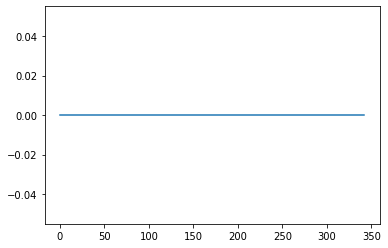

In [17]:
import matplotlib.pyplot as plt
plt.plot(trials['laser_stim'])

In [18]:
trials['laser_stim'].mean()

0.0

In [19]:
master_matrix.to_csv(os.path.join(savedir,f'lynne_no_thresh_full_{nBack}_local_tet.csv'),index=True)
os.system('say "script done"')

0

# thresholding data
## add labels for `Condition`, `TargetPort`, `Block` info, `session_pos` 

In [20]:
# def master_df_conditions(r, **kwargs):
    
#     '''return session IDs that meet designated conditions to pass through history df'''
#     blocks = kwargs.get('blocks', False)
#     threshold = kwargs.get('threshold', False)
    
#     if blocks:
#         r = r[r['No. Blocks']>0.0].copy()
        
# #     count=0
# #     n_skipped = 0
        
#     if threshold:
        
#         # set threshold for inclusion based on reward parameters
#         #threshold = r['p(high Port)'].mean() - (1 * r['p(high Port)'].std())
#         threshold = 0.7
#         propAbove = len(r[r['p(high Port)'] > threshold]) / len(r)
#         print(f'{propAbove} trials above threshold of {threshold}')
#         r = r[r['p(high Port)'] > threshold].copy()
        
# #         if threshold<0.7:
# #             n_skipped += 1
# #             continue
            
#     return list(r['Session ID'].values)

# # print(f'final n skipped: {n_skipped}')


In [21]:
# sessions_included = master_df_conditions(record_df, threshold=True)
# print(len(sessions_included))
# print(len(record_df))

In [22]:
# record_df.head()

In [23]:
# master_matrix_thresholded = master_matrix.loc[master_matrix['Session ID'].isin(sessions_included)]

In [24]:
# master_matrix_thresholded.head()

In [25]:
#master_df_conditions(record_df.loc[record_df['Right Reward Prob'].isin([0.9,0.1])], threshold=True)

In [26]:
# master_matrix_thresholded.to_csv(os.path.join(savedir,f'lynne_thresh_full_{nBack}back_D2RKO.csv'),index=True)